In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# TODO:

- create groupings for services rendered 
- give the conditional probability of multiple procedures being accounted for
- give a cost estimate for the procedures given a users insurance / location
- suggest the top 3 recommendations based on the criteria

## Load data

In [3]:
ma_data = pd.read_csv('data/CHAI_MA-cost-estimates.csv')
nh_data = pd.read_csv('data/NHID_cost-estimates.csv')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,7,47,48,49,51,52,53,55,56,57) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
print('num rows massachussetts data:', len(ma_data))
print('num rows new hampshire data:', len(nh_data))

num rows massachussetts data: 113813
num rows new hampshire data: 67809


## Filter data down to columns of relevance

In [5]:
ma_data_slim = ma_data[['ProviderOrgName_Anchored', 'ProviderTaxonomyType', 'ProviderTaxonomyGroup',  'ZIP',
 'ServiceCode',
 'CostEstimate',
 'NumberServices',
 'ServiceType_Level1',
 'ServiceType_Level2',
 'ServiceType_Level3',
 'ServiceType_Level4',
 'ServiceDescription',
 'NumberProvs_forPayerAndService',
 'NumberServices_All',
 'TotalCost_All']].sample(frac=1)

In [6]:
nh_data_slim = nh_data[['PROCEDURE_CODE',
 'PROCEDURE_NAME',
 'SHORT_DESCRIPTION',
 'CATEGORY_NAME',
 'COVERAGE_CLASS',
 ' MED_ALLOW ',
 'PRICE_PERCISION',
 'PATIENT_COMPLEXITY',
 'PAYER',
 'PLAN_TYPE',
 'PROVIDER_NAME']].sample(frac=1)

## Basic Preprocessing

In [7]:
nh_data_slim['PROCEDURE_CODE_STR']= nh_data_slim.PROCEDURE_CODE.apply(str)

In [8]:
ma_data_slim['ServiceCode_STR'] = ma_data_slim.ServiceCode.apply(str)

### Group services into buckets

In [9]:
nh_data_slim.CATEGORY_NAME.value_counts()

Diagnostic Services                12265
Office Visits                      11074
Dental Fillings                     8418
Laboratory Services                 7410
Behavioral Health Care              7233
Preventive Care                     6219
Physical Therapy                    4963
Radiology Services                  3459
Other Dental Services               1755
Ambulance Services                  1625
Outpatient Tests and Procedures     1378
Chiropractic Care                   1377
Emergency Visits                     511
Orthodontic Services                 122
Name: CATEGORY_NAME, dtype: int64

In [10]:
ma_data_slim.ServiceType_Level1.value_counts()

Office Visits                        61905
Behavioral Health                    17815
Physical and Occupational Therapy    11109
Laboratory and Pathology Testing     10378
Radiology                             6342
Eye exams                             3499
Ambulance/Transportation Services      949
Colonoscopy and Endoscopy              706
Maternity                              684
Emergency Department Visits            426
Name: ServiceType_Level1, dtype: int64

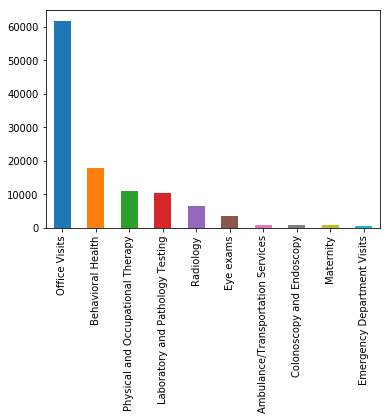

In [11]:
ma_data_slim['ServiceType_Level1'].value_counts().plot(kind='bar')

In [12]:
ma_data_slim.loc[ma_data_slim.ServiceType_Level1 == 'Emergency Department Visits']['ServiceType_Level2'].value_counts()

Moderate severity problems                         114
High severity but non-life-threatening problems     96
Low to moderate severity problems                   85
Life-threatening problems                           74
Minor problems                                      57
Name: ServiceType_Level2, dtype: int64

In [13]:
ma_data_slim.loc[ma_data_slim.ServiceType_Level1 == 'Emergency Department Visits']['ServiceType_Level3'].value_counts()

Series([], Name: ServiceType_Level3, dtype: int64)

In [14]:
ma_data_slim.loc[ma_data_slim.ServiceType_Level1 == 'Emergency Department Visits']['ServiceType_Level4'].value_counts()

Series([], Name: ServiceType_Level4, dtype: int64)

In [15]:
ma_data_slim.loc[ma_data_slim.ServiceType_Level1 == 'Office Visits']['ServiceType_Level2'].value_counts()

Presenting with a problem    45763
Preventive care              14537
Consultation                  1605
Name: ServiceType_Level2, dtype: int64

In [16]:
ma_data_slim.loc[ma_data_slim.ServiceType_Level1 == 'Office Visits']['ServiceType_Level3'].value_counts()

Established patient    47788
New patient            12512
60 minutes               751
40 minutes               611
80 minutes               132
30 minutes                99
15 minutes                12
Name: ServiceType_Level3, dtype: int64

In [17]:
ma_data_slim.loc[ma_data_slim.ServiceType_Level1 == 'Office Visits']['ServiceType_Level4'].value_counts()

15 minutes         15090
25 minutes         12994
Age 18 to 39        5107
Age 40 to 64        4807
30 minutes          4291
10 minutes          4007
45 minutes          3626
40 minutes          2381
20 minutes          1433
Age 0 to 1          1187
60 minutes          1177
Age 5 to 11         1114
Age 12 to 17        1045
Age 1 to 4           840
5 minutes            764
Age 65 or older      437
Name: ServiceType_Level4, dtype: int64

## CPT codes mapping between data sets

- <b>nh_data.PROCEDURE_CODE is equal to ma_data.ServiceCode</b>

In [18]:
nh_data_slim.loc[nh_data_slim.PROCEDURE_CODE_STR == '70450'].head()

,PROCEDURE_CODE,PROCEDURE_NAME,SHORT_DESCRIPTION,CATEGORY_NAME,COVERAGE_CLASS,MED_ALLOW,PRICE_PERCISION,PATIENT_COMPLEXITY,PAYER,PLAN_TYPE,PROVIDER_NAME,PROCEDURE_CODE_STR
1506,70450,"CT - Head/Brain, without dye","CT - Head/Brain, without dye",Radiology Services,MED,"$1,522",VERY LOW,MEDIUM,Other Medical Insurance,Group (employer) Medical Plans,ELLIOT HOSPITAL,70450
1494,70450,"CT - Head/Brain, without dye","CT - Head/Brain, without dye",Radiology Services,MED,$348,MEDIUM,MEDIUM,Anthem - NH,Individual (self-purchased) Medical Plans,SOUTHERN NH MEDICAL CENTER,70450
1491,70450,"CT - Head/Brain, without dye","CT - Head/Brain, without dye",Radiology Services,MED,"$1,766",MEDIUM,HIGH,Harvard Pilgrim HC,Group (employer) Medical Plans,PORTSMOUTH REGIONAL HOSPITAL,70450
1478,70450,"CT - Head/Brain, without dye","CT - Head/Brain, without dye",Radiology Services,MED,$776,MEDIUM,MEDIUM,Anthem - NH,Group (employer) Medical Plans,ST. JOSEPH HOSPITAL,70450
1479,70450,"CT - Head/Brain, without dye","CT - Head/Brain, without dye",Radiology Services,MED,"$1,298",MEDIUM,MEDIUM,Cigna,Group (employer) Medical Plans,ST. JOSEPH HOSPITAL,70450


In [19]:
ma_data_slim.loc[ma_data_slim.ServiceCode_STR == '70450'].head()

,ProviderOrgName_Anchored,ProviderTaxonomyType,ProviderTaxonomyGroup,ZIP,ServiceCode,CostEstimate,NumberServices,ServiceType_Level1,ServiceType_Level2,ServiceType_Level3,ServiceType_Level4,ServiceDescription,NumberProvs_forPayerAndService,NumberServices_All,TotalCost_All,ServiceCode_STR
1286,Baystate Franklin Medical Center,General Acute Care Hospital,Acute Hospital,1301,70450,511.84,111,Radiology,CT Scan,Head or brain,Without contrast,"CT scan of head or brain, diagnostic, without ...",105,111,56506.20,70450
1313,"Massachusetts General Physicians Organization,...",Multi-Specialty Organization,Multi-Specialty Organization,2114,70450,382.25,116,Radiology,CT Scan,Head or brain,Without contrast,"CT scan of head or brain, diagnostic, without ...",105,116,44957.12,70450
1377,St. Luke's Hospital,General Acute Care Hospital,Acute Hospital,2740,70450,331.43,516,Radiology,CT Scan,Head or brain,Without contrast,"CT scan of head or brain, diagnostic, without ...",105,516,167867.34,70450
1299,South County Hospital Healthcare System,General Acute Care Hospital,Acute Hospital,2879,70450,973.33,23,Radiology,CT Scan,Head or brain,Without contrast,"CT scan of head or brain, diagnostic, without ...",105,23,20173.60,70450
1321,Norwood Urgent Care,Clinic/Center,Clinic,2062,70450,283.86,52,Radiology,CT Scan,Head or brain,Without contrast,"CT scan of head or brain, diagnostic, without ...",105,52,12535.34,70450


In [20]:
nh_data_slim[['PROCEDURE_CODE', 'PROCEDURE_NAME']].head(20)

,PROCEDURE_CODE,PROCEDURE_NAME
39435,D0120,Periodic dental exam - established patient
17791,90837,60 Minute - Psychotherapy
55226,D1206,Topical fluoride varnish application
59760,D2160,Silver (Amalgam) Dental Filling - Three surfac...
22354,97140,Manual Therapy - PT
46262,D0220,X-Ray Dental - Intraoral - periapical radiogra...
36517,99396,Comp Preventive Medicine 40-64 yrs old
26606,99203,"Office Visit, New Pt, Low"
6058,80061,Lipid Panel - Cholesterol Test
12683,90791,Diagnostic Evaluation - Psychiatric


## Breakdown of services and costs rendered by Provider

In [21]:
ma_data_slim.groupby('ProviderOrgName_Anchored')[['ServiceCode', 'CostEstimate']].agg({'ServiceCode': lambda x: list(x), 'CostEstimate': ['sum', 'mean', 'median']})

ServiceCode  \
                                                                                             <lambda>   
ProviderOrgName_Anchored                                                                                
1 On 1 Eyecare                                                                         [92004, 92014]   
2 Thumbs Up Hand Therapy LLC                        [97110, 97003, 97140, 97530, 97140, 97003, 971...   
20 20 Eye Care PC                                                 [92012, 92002, 92004, 92014, 99213]   
60 Quaker Highway Inc.                                     [97002, 97530, 97112, 97110, 97001, 97140]   
711 Pedicare                                                                                  [99214]   
A Better Way To Cope: Psychotherapy And Consult...                                     [90834, 90834]   
A Chiropractic Wellness Place PC                                                              [97112]   
A F Calvanese MD PC                                 [99213, 99212, 99395, 99396, 99214, 99215, 993...   
A Gale Maynard LICSW                                                                   [90834, 90791]   
A Plus Chiropractic Management Inc                                [97012, 99213, 97110, 97140, 97110]   
A Richard Cote M.D.                                        [92004, 92014, 92002, 99213, 99212, 92012]   
A Step Above Physical Therapy                              [97110, 97112, 97530, 97530, 97002, 97110]   
A Touch of Health Chiropractic, LLC                                                    [97012, 97110]   
A.F.A. Obstetrics & Gynecology, P.C.                [99396, 99203, 99214, 99395, 99214, 99395, 992...   
ATI Physical Therapy of Western Massachusetts       [97112, 97110, 97110, 97001, 97140, 97002, 970...   
Aafaque Akhter M.D.                                                                           [99213]   
Aaron A Hoffman MA                                                              [90791, 90847, 90834]   
Aaron C Drouin D.C.                                                                           [97140]   
Aaron M Selfridge D.C.                                                          [97140, 99203, 97110]   
Aaron Mathew Walsh D.C.                                                                       [97112]   
Aaron Michael Price LICSW                                                                     [90834]   
Aarrow Straight Chiropractic                                      [97110, 97530, 97012, 97012, 97112]   
Aarti Khullar PsyD                                                                            [90834]   
Aasp Allergy & Asthma Specialty Physicians, PC      [99244, 99212, 99213, 99203, 99204, 99213, 99213]   
Abacus Health & Wellness, LLC                                                          [97140, 97112]   
Abbey Medical Associates PC                                       [99386, 99204, 99213, 99396, 99214]   
Abbie Rosenberg RN CS                                                           [99214, 99213, 90834]   
Abby Lisa Stein M.Ed.,LICSW                                                                   [90834]   
Abby Rodman LICSW                                                                             [90834]   
Abby Seixas L.M.H.C.                                                                          [90834]   
Abc Family Chiropractic And Wellness Inc.                                                     [97012]   
Abc Health Services Inc                                                                [97112, 72100]   
Abdul Ghaffar M.D.                                                                            [99204]   
Abdul M Khadra M.D.                                                                    [99214, 99395]   
Abelard Psychotherapy, LLC                          [99214, 90834, 90834, 99214, 90834, 90792, 907...   
Abigail B Blackburn Psy.D.                                                             [90837, 90834

## Mapping of Service Codes to available Provider and aggregate cost of service

In [22]:
ma_data_slim.groupby('ServiceCode')[['ProviderOrgName_Anchored', 'CostEstimate']].agg({'ProviderOrgName_Anchored': lambda x: list(x), 'CostEstimate': ['sum', 'mean', 'median']})

ProviderOrgName_Anchored  \
                                                             <lambda>   
ServiceCode                                                             
90847               [Kathleen K Davis PhD, LICSW, Alan Roy PsyD LL...   
90853               [Joseph Papa MSW, Barbara J Samek LICSW, Lisa ...   
92002               [Lexington Eye Associates, Inc, James Andrews ...   
92004               [Fischer Eye Care PC, Twin City Eye Care, Eye ...   
92012               [Kem Optical P.C., D'Ambrosio Eye Care, Inc., ...   
92014               [Braintree Vision Associates, Lynn Community H...   
96101               [Child Development Network, Boston Psychologic...   
96102               [Child & Family Psychological Services, Inc., ...   
96103               [Child & Family Psychological Services, Inc., ...   
96105               [Psycholinguistic Associates, Inc., Childrens ...   
96111               [Massachusetts General Physicians Organization...   
96116               [Baystate Medical Center, Brigham And Women's ...   
96118               [Massachusetts General Physicians Organization...   
96119               [Brigham And Women's Physicians Organization -...   
96120               [Child & Family Psychological Services, Inc., ...   
96150               [Bridgewater Pediatrics LLC, Child & Family Ps...   
96151               [Bridgewater Pediatrics LLC, Sandra L Crump Ph...   
96152               [New Horizon Health And Wellness, Jonathan Edw...   
96153               [Bay Cove Early Intervention, Associates for H...   
96154               [Neuro-Psychology Associates of Western Massac...   
96155                                [Pathways of Massachusetts, LLC]   
97001               [Prescription Orthopedic And Sports Therapy, O...   
97002               [Marathon Physical Therapy And Sports Medicine...   
97003               [Excel Orthopedic Specialists, Harmeling Physi...   
97004               [Children's Hospital Boston, Cooley Dickinson ...   
97012               [Seth L Levine DC, O'Brien Chiropractic Office...   
97016               [Excel Orthopaedic Specialists, Jump Start Phy...   
97110               [Apple Nashua, West Bay Orthopaedics And Neuro...   
97112               [Bay State Physical Therapy of Randolph PC, Pa...   
97116               [Ashland Physical Therapy & Sports Medicine, I...   
97124               [Sandwich Physical Therapy, Inc, Daniel P. Dre...   
97140               [Doctor's Physio, Healthsouth Rehabilitation H...   
97150               [Whittier Rehabilitation Hospital-Westborough,...   
97530               [Orthopedic Rehab Associates PC, South Shore T...   
97535               [Massachusetts Eye And Ear Infirmary, Blue Hil...   
97750               [South Shore Hospital Inc., ObGyn Associates o...   
97760               [Beth Israel Deaconess Hospital Milton Inc, Sa...   
97762               [Massachusetts General Hospital, Lahey Clinic ...   
99201               [Merrimack Valley Oral Surgeons, Inc, North En...   
99202               [Lowell Surgical Associates, P.C., Middlesex S...   
99203               [Medical Care of Boston Management Corporation...   
99204               [Woman Well Inc, Cambridge Otolaryngology, UMA...   
99205               [Mt Auburn Professional Services, Massachusett...   
99211               [Pediatrics at Newton Wellesley, PC, East Moun...   
99212               [Foundation Medical Partners Inc, South Shore ...   
99213               [Medical Care of Boston Management Corporation...   
99214               [Harvard Vanguard Medical Associates, Harvard ...   
99215               [Brigham And Women's Physicians Organization -...   
99241               [Massachusetts General Physicians Organization...   
99242               [Dermatology - HMFP at BIDMC, Robert J Obrien ...   
...                                                               ...   
86706               [Cambridge Health Alliance, Diagnostic Laborat...   
86787               [Quest Dia